### 通讯录：
- 每个人通讯录的个数的分布
- 每个人存在联系人的个数分布
- 通讯录中保持电话联系，短信联系及同时有电话和短信的联系的人的比率
- 不同性别、年龄之间的差异

#### 结论1：
- 通讯录人数、通讯录中的联系人数，以及其比率在性别与年龄之间的差异
- 图一：通讯录人数在不同年龄及性别之间的差异
- 图二：联系人数在不同年龄及性别之间的差异
- 图三：内聚率（通讯录中存在联系的占通讯录总数的比率）在不同年龄与性别之间的差异
从三张图中会发现不同年龄及性别之间在维持社交关系的广度、深度上的不同，总结规律。

In [1]:
%matplotlib inline
from impala.dbapi  import connect
from sqlalchemy import *  
from sqlalchemy.sql import select  
from sqlalchemy.schema import *  
import numpy as np
import pandas as pd
from sqlalchemy.orm import sessionmaker
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
from pylab import mpl
myfont = matplotlib.font_manager.FontProperties(fname='fonts/simhei.ttf')  
mpl.rcParams['axes.unicode_minus'] = False 
def getPlot(df,lable='x',title='y'):
    ax=by_age_sex(df,lable)
    plt.plot(ax.index,ax[0.0],':rs',label='female')
    plt.legend(loc=2)
    plt.plot(ax.index,ax[1.0],'-ko',label='male')
    plt.legend(loc=2)
    plt.title(title,fontproperties=myfont)
    plt.xlabel('age')

# conn=connect(host="192.168.61.168",port=21050,user="yudang.wei",password="19900410w",auth_mechanism="GSSAPI")

In [2]:
cust_user_info=pd.read_csv("data/fdl_cust_user_info_chain_0228.csv",index_col=0).drop_duplicates('custorm_id').set_index('custorm_id')
# ## 通讯录人数
# select custorm_id,count(distinct number) from (select * from  app_contacts_hive where  name is not NULL and length(number)>6)d  group by custorm_id 

# ## 存在联系人的个数
# select custorm_id,count(distinct number) from app_call_record_hive  group by custorm_id having name is not NULL and length(number)>6

# ## 存在短信联系的人数  cast(name as float) is NULL

# select custorm_id,count(distinct number) from (select * from app_sms_hive where name is not NULL and length(phone)>6 )d group by custorm_id

## 一。通讯录数据分析

### 1.1 数据读取与整合

In [3]:

convert_index=lambda filePath:pd.read_csv(filePath,index_col=0).set_index('custorm_id')
# connect_num.set_index('custorm_id',inplace=True)
connect_num=convert_index("MSN/connect_num.csv")
contact_num=convert_index("MSN/contact_num.csv")
sms_connect_nums=convert_index("MSN/sms_connect_nums.csv")
connect_num.index=connect_num.index.astype('string')
contact_num=contact_num[contact_num.contact_num<1000]


In [4]:
contact_num.shape,connect_num.shape,sms_connect_nums.shape,cust_user_info.shape

((1675606, 1), (1027812, 1), (1305815, 1), (7359716, 2))

In [54]:
contact_num.head(3)

,id_no,reg_src,contact_num,age,sex
custorm_id,,,,,
2646151,61012119680319-b1b,Android,48,48.0,male
2047692,34122119900319\L14,Android,100,26.0,male
46255,37061119850311eE1s,iOS,297,31.0,male


In [5]:
cust_user_info.index.name='custorm_id'
cust_user_info.index=cust_user_info.index.astype('string')

In [6]:
def get_PersonInfo(contact_num):
    contact_num=cust_user_info.join(contact_num,how='inner',rsuffix='x')
    contact_num["age"]=2016-contact_num.id_no.str.slice(6,10).astype("float")
    ##奇数为男性，偶数为女性
    contact_num["sex"]=contact_num.id_no.str.slice(16,17).bfill().replace('','0').astype("float")%2
    contact_num.sex.replace({1.0:'male',0.0:'female'},inplace=True)
    contact_numa=contact_num[(contact_num.age>10) &(contact_num.age<60)]
    return  contact_num

In [7]:
contact_connect=contact_num.join(connect_num.connect_num,how='inner')  ## 通讯录个数 保持联系的个数


In [8]:
contact_connect=contact_num.join(connect_num.connect_num,how='inner')  ## 通讯录个数 保持联系的个数
contact_connect['connect_contact_rate']=contact_connect.connect_num.values/contact_connect.contact_num.values.astype('float')

In [10]:
ccSMS=contact_num.join(sms_connect_nums,how='inner')   ## 再加短信来往
ccSMS['sms_contact']=ccSMS.sms_connect_num.values/ccSMS.contact_num.values.astype('float')
ccSMS=get_PersonInfo(ccSMS).ix[:,['contact_num','sex','age','sms_contact']]
contact_connect_rate=get_PersonInfo(contact_connect).ix[:,['sex','age','connect_contact_rate']]

In [11]:
contact_num=get_PersonInfo(contact_num)
connect_num=get_PersonInfo(connect_num)

In [12]:
ccSMS=contact_num.join(sms_connect_nums,how='inner')   ## 再加短信来往


In [13]:
ccSMS['sms_ERR']=ccSMS.sms_connect_num.values/ccSMS.contact_num.values.astype('float')


In [14]:
sms_cdr=sms_connect_nums.join(connect_num,how='inner')
sms_cdr['IRR']=sms_cdr.sms_connect_num.values/sms_cdr.connect_num.values.astype('float')

In [15]:
contact_num[contact_num.contact_num<500].contact_num.mean()

144.39105239647608

In [16]:
connect_num[connect_num.connect_num<100].connect_num.mean()

35.40799832721351

In [18]:
ccSMS.sms_connect_num.mean()

11.338677185188434

In [43]:
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

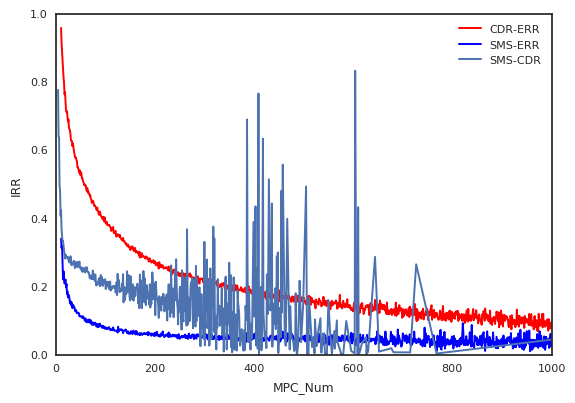

In [44]:
ax=contact_connect.groupby('contact_num').mean()['connect_contact_rate'][10:].plot(color='red',label='CDR-ERR')
ccSMS.groupby('contact_num').mean()['sms_ERR'][10:].plot(label='SMS-ERR',color='b',marker='1')
msm_cdr=sms_cdr.groupby('connect_num').mean()['IRR']
msm_cdr=msm_cdr[msm_cdr<1.0]
msm_cdr.plot(xlim=[0,1000],label='SMS-CDR')
ax.set_xlabel('MPC_Num')
ax.set_ylabel('IRR')
ax.legend()
# ax.set_axis_bgcolor('white')
# ax.grid()

### 1.2. 数据分析与研究

In [20]:
# contact_num_cnt=contact_num.contact_num.value_counts().sort_index()
# contact_num_cnt_rate=contact_num_cnt.cumsum()/contact_num_cnt.sum()
# connect_num_cnt=connect_num.connect_num.value_counts().sort_index()
# connect_num_cnt_rate=connect_num_cnt.cumsum()/connect_num_cnt.sum()
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 8),sharex=True)
# axes[0,0].plot(contact_num_cnt_rate.index,contact_num_cnt_rate.values,'-r',label='contact_num')
# axes[1,0].plot(contact_num_cnt.index,contact_num_cnt.values,'-r',label='contact_num')
# axes[1,0].set_yscale('log')
# axes[0,1].plot(connect_num_cnt_rate.index,connect_num_cnt_rate.values,'-k',label='connect_num')
# axes[1,1].plot(connect_num_cnt.index,connect_num_cnt.values,'-k',label='connect_num')
# axes[1,1].set_yscale('log')
# axes[1,1].set_xlabel(u"常联系人数",fontproperties=myfont)
# axes[1,0].set_xlabel(u"通讯录",fontproperties=myfont)
# for axl in axes.flatten():
# #     ax.set_yscale('log')
#     axl.set_xlim([0,1000])
#     axl.legend(loc=1)
# #     axl.set_xlabel(u"好友",fontproperties=myfont)
# fig.subplots_adjust(wspace=0.1,hspace=0.05)
### 幂律分布而验证函数
from scipy import stats
def Power_law(df):
    x=np.log(df.index.values)
    y=np.log(df.values)
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(x, y)
    return slope,p_value,r_value,slope_std_error

#### 1.2.1 通讯录整体分析

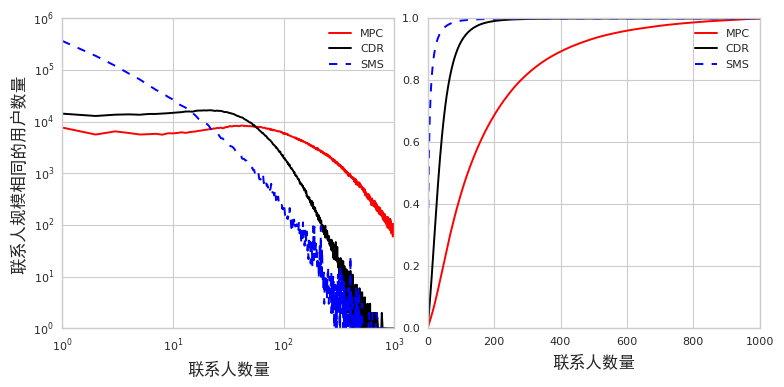

In [69]:
contact_num_cnt=contact_num.contact_num.value_counts().sort_index()
contact_num_cnt_rate=contact_num_cnt.cumsum()/contact_num_cnt.sum()
connect_num_cnt=connect_num.connect_num.value_counts().sort_index()
connect_num_cnt_rate=connect_num_cnt.cumsum()/connect_num_cnt.sum()
sms_cnt=sms_connect_nums.sms_connect_num.value_counts().sort_index()
sms_cnt_rate=sms_cnt.cumsum()/sms_cnt.sum()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),facecolor='white')


axes[0].plot(contact_num_cnt.index,contact_num_cnt.values,'-r',label='MPC')
axes[0].plot(connect_num_cnt.index,connect_num_cnt.values,'-k',label='CDR')
axes[0].plot(sms_cnt.index,sms_cnt.values,'--b',label='SMS')
axes[0].set_yscale('log')
axes[0].set_xscale('log')

# axes[0].set_xscale('log')
axes[0].set_ylabel(u'联系人规模相同的用户数量',fontproperties=myfont)

axes[1].plot(contact_num_cnt_rate.index,contact_num_cnt_rate.values,'-r',label='MPC')
axes[1].plot(connect_num_cnt_rate.index,connect_num_cnt_rate.values,'-k',label='CDR')

axes[1].plot(sms_cnt_rate.index,sms_cnt_rate.values,'--b',label='SMS')
# axes[1].set_axis_bgcolor('white')

# axes[1,0].set_yscale('log')

# axes[0].set_ylim([0,100000])

# axes[1].set_xlabel(u"常联系人数",fontproperties=myfont)
# axes[1].set_xlabel(u"通讯录",fontproperties=myfont)
for axl in axes.flatten():
#     ax.set_yscale('log')
    axl.set_xlim([0,1000])
    axl.legend(loc=1)

    axl.set_xlabel(u"联系人数量",fontproperties=myfont)
fig.subplots_adjust(wspace=0.1,hspace=0.05)


通联数据幂律分布
横坐标为用户的度，具有相同联系人数量的用户个数为纵轴，通过对纵轴取对数之后，得到的通信录、电话常联系人，短信联系人三种通联数据服从幂律分布指数@分别是：1.3，2.8，2.6
- 我们发现在用户的联系人分布曲线的下降沿有‘厚尾’特性，即在图中右下角有很多的波动的样本点
- 通讯录人数，常联系人数，短信联系人数服从幂律分布
> 这段内容参考：
> - 1。基于移动网络数据的用户行为与城市感知研究[2.1.2]章节【移动通信数据幂律分布】

In [124]:
connect_num.connect_num.quantile(0.73)

55.0

In [129]:
contact_connect.contact_num.quantile(0.8)

263.0

In [116]:
sms_connect_nums.sms_connect_num.quantile(0.9)

22.0

In [ ]:
Power_law(connect_num_cnt)

In [ ]:
Power_law(sms_cnt)

In [146]:
def get_plot(connect_num,y='connect_num',style='--k*',ax=None):
    cond=(connect_num.age>15)&(connect_num.age<60)
#     connect_num_info=connect_num[cond].groupby('sex').apply(lambda  x:x.groupby('age').mean())
    connect_num_info=connect_num[cond].groupby('age').mean() 
#     female=connect_num_info.loc['female']
#     male=connect_num_info.loc['male']
#     plt.figure(figsize=(8,6))
    ax.plot(connect_num_info.index,connect_num_info.values,style)
#     ax.plot(male.index,male.values,'-go',label='male')
#     ax.set_title(y,fontproperties=myfont)
#     ax.set_xlabel(x)
   
    return ax
    
    
#     g=sns.factorplot(x='age',y=y,hue='sex',data=connect_num_info,size=10,rot=70,markers=["o", "x"])
#     g.set_xticklabels(rotation=60)
#     g.set_titles(y)

#### 1.2.2  移动社交网络的度在年龄与性别之间的差异

In [58]:
sns.set_context('paper')
sns.set_style('whitegrid')

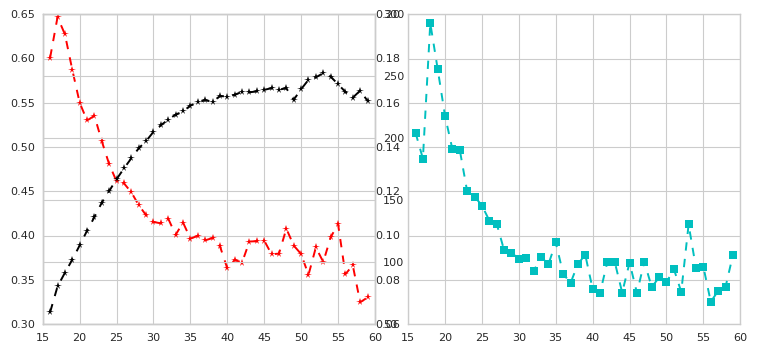

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax3,ax4=axes.flatten()
# get_plot(contact_num,y=u'MPC',ax=ax1,x='(a)')   ## 
get_plot(contact_connect_rate,y=u'CDR-ERR',ax=ax3,style='--r*')
ax3=ax3.twinx()
get_plot(contact_num,y=u'MPC',ax=ax3)  ## 

get_plot(get_PersonInfo(ccSMS.ix[:,['sex','age','sms_ERR']]),y=u'SMS-ERR',ax=ax4,style='--cs')
get_plot(connect_num[(connect_num.connect_num<1000)],y=u'CDR',ax=ax2)

# get_plot(contact_connect_rate,y=u'CDR-ERR',ax=ax3,style='-go')
ax3.legend(loc=1)
fig.subplots_adjust(wspace=0.1,hspace=0.25)


- 1 .  通讯录人数、常联系的人数与年龄成正相关关系
- 2 . 通讯录人数、常联系人数上，男性要比女性高
- 3 .  联系人数与通讯录人数及短信联系人数与通信录人数的比值与年龄成负相关关系
- 4 .  个体虽然随着年龄增加，起社交范围虽然也增加，但是其能够保持紧密群体数量却在趋于稳定即30-50人之间。所以导致聚集系数与年龄成负相关的关系


In [68]:
def get_plot(connect_num,ax=None,maker=[':r','-k'],labels=['female','male']):
    cond=(connect_num.age>15)&(connect_num.age<60)
    connect_num_info=connect_num[cond].groupby('sex').apply(lambda  x:x.groupby('age').mean())
  
    female=connect_num_info.loc['female']
    male=connect_num_info.loc['male']
#     plt.figure(figsize=(8,6))
    ax.plot(female.index,female.values,maker[0],label=labels[0])
    ax.plot(male.index,male.values,maker[1],label=labels[1])
    
   
    return ax

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),sharex=True)
ax1,ax2=axes.flatten()
ax1=get_plot(contact_num,ax=ax1,labels=['female_contact','female_contact'])   ## 
ax1.set_ylabel(u'通讯录人数',fontproperties=myfont)
ax3=ax1.twinx()
get_plot(connect_num[(connect_num.connect_num<1000)],ax=ax3,maker=[':b','-g'],labels=['female_phone_contact','female_phone_contact'])
ax3.set_ylabel(u'常联系人数',fontproperties=myfont)
ax2=get_plot(contact_connect_rate,ax=ax2,labels=['female_phone_in_con','male_phone_in_con'])
ax2.set_ylabel(u'电话联系人占通讯录的比',fontproperties=myfont)

ax4=ax2.twinx()
ax4=get_plot(get_PersonInfo(ccSMS),ax=ax4,labels=['female_sms_in_con','male_sms_in_con'],maker=[':b','-g'])
ax1.legend(loc=2) 
ax3.legend(loc=4)  
fig.subplots_adjust(wspace=0.5,hspace=0.2)

In [ ]:
# sms_cnt=sms_connect_nums.sms_connect_num.value_counts().sort_index()
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),sharex=True)

# axes[0].plot(sms_cnt.index,sms_cnt.values,'-k')
# axes[0].set_yscale('log')
# sms_cnt=sms_cnt.cumsum()/sms_cnt.sum()
# axes[1].plot(sms_cnt.index,sms_cnt.values,'-k')
# table_text=[str(line)[:5] for line in  sms_cnt.values[:25:5]*100]
# plt.table(cellText=[range(1,25,5), table_text],alpha=0,
#          loc=3.1)
# for ax in axes:
#     ax.set_xlim([0,200])
#     ax.set_xlabel(u'短信联系人',fontproperties=myfont)
# fig.tight_layout()


In [ ]:
np.round(3.1415926,1)

In [ ]:
[str(line)[:5] for line in  sms_cnt.values[:25:5]*100]

In [ ]:
range(1,25,5)

In [ ]:
cc=contact_connect_rate.groupby('sex').apply(lambda  x:x.groupby('age').mean())

- 图一  通讯录中联系人数量在不同年龄与性别之间的差异

In [ ]:
get_plot(contact_num,y='contact_num')   ## 

- 图二 联系人数量在不同年龄与性别之间的差异

In [ ]:

get_plot(connect_num[(connect_num.connect_num<1000)])


- 图三  保持联系的人数占通讯录总数的比例

In [ ]:
get_plot(get_PersonInfo(contact_connect),y='connect_contact_rate')

- 图四 通过短信联系的人占通讯的比例

In [50]:
x=ccSMS[(ccSMS.age>16)&(ccSMS.age<60)].groupby('sex').apply(lambda  x:x.groupby('age').mean())


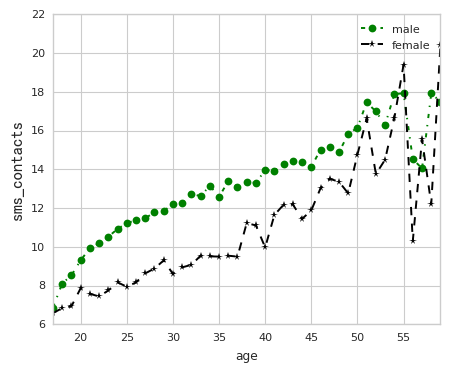

In [68]:
ax=x.loc['male'].sms_connect_num.plot(label='male',style='-.go',figsize=(5,4))
ax=x.loc['female'].sms_connect_num.plot(label='female',ax=ax,style='--k*')
ax.set_ylabel(u'sms_contacts',fontproperties=myfont)
ax.legend()

In [76]:
get_plot(ccSMS.ix[:,['age','sex','sms_connect_num']],y='sms_connect_num')

AttributeError: 'NoneType' object has no attribute 'plot'

In [ ]:
get_plot(get_PersonInfo(ccSMS),y='sms_connect_num')  ## 短信联系人的个数